In [ ]:
!pip install langgraph langchain_openai langchain_core httpx

In [2]:
import os
import glob
from typing import Annotated, List, Literal
from langgraph.graph import StateGraph, END
from langchain_openai import AzureOpenAI
from langchain_openai import AzureChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage


from typing_extensions import TypedDict ,Optional, List, Dict, Any
from langgraph.graph.message import add_messages

from langchain_core.pydantic_v1 import BaseModel, Field
from langgraph.checkpoint.memory import MemorySaver


import os

os.environ["OPENAI_API_VERSION"] = "2024-xx-xx-preview"
os.environ["AZURE_OPENAI_ENDPOINT"] = "https://xxxxx.openai.azure.com"
os.environ["AZURE_OPENAI_API_KEY"] = "xxxxx"


model = AzureChatOpenAI(
    azure_deployment="gpt-4o",  # or your deployment
    temperature=0,
)



/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
# グラフを流れるStateの方の定義
class State(TypedDict, total=False):
    message_type: Optional[str]
    messages: Optional[str]
    bool_time: Optional[bool]
    advance_messages:Optional[str]

# 日付か天気かの質問分類器の出力
class MessageType(BaseModel):
    message_type: str = Field(description="The type of the message", example="search")

# 天気の質問において、必要情報がすでに埋まっているかを判定する判定器の出力
class TimeType(BaseModel):
    message_type: bool = Field(description="The bool of the time", example=True)

# 今日、明日、明後日のどのワークフローを選択するかの分類器の出力
class ToolType(BaseModel):
    message_type: str = Field(description="Must use the Tool", example="tool01")

In [4]:
from langgraph.errors import NodeInterrupt

def interrupt(State):
    print("--interrupt--")
    if not State["bool_time"]:
      raise NodeInterrupt("天気を知りたい時間を入力してください")

    return {
            "message_type":State["message_type"] ,
            "messages":State["messages"],
            "bool_time": State["bool_time"],
            "advance_messages":"None"
            }


def chat_w1(State):
    print("--chat_w1--")
    if State["messages"]:
        State["messages"][0] = ("system", "あなたはユーザからの質問を繰り返してください。その後、質問に回答してください。ただし今日の午前は雨で、午後は雪です")
        return {"messages": model.invoke(State["messages"])}
    return {"messages": "No user input provided"}

def chat_d1(State):
    print("--chat_d1--")
    if State["messages"]:
        State["messages"][0] = ("system", "あなたはユーザの質問内容を繰り返し発言した後、それに対して回答してください。ただし今日は10/23です")
        return {"messages": model.invoke(State["messages"])}
    return {"messages": "No user input provided"}

def chat_w2(State):
    print("--chat_w2--")
    if State["messages"]:
        State["messages"][0] = ("system", "あなたはユーザからの質問を繰り返してください。その後、質問に回答してください。ただし明日の午前は曇りで、午後は霰です")
        return {"messages": model.invoke(State["messages"])}
    return {"messages": "No user input provided"}

def chat_d2(State):
    print("--chat_d2--")
    if State["messages"]:
        State["messages"][0] = ("system", "あなたはユーザの質問内容を繰り返し発言した後、それに対して回答してください。ただし明日は10/24です")
        return {"messages": model.invoke(State["messages"])}
    return {"messages": "No user input provided"}

def chat_w3(State):
    print("--chat_w3--")
    if State["messages"]:
        State["messages"][0] = ("system", "あなたはユーザからの質問を繰り返してください。その後、質問に回答してください。ただし明後日の午前は晴れで、午後は霧です")
        return {"messages": model.invoke(State["messages"])}
    return {"messages": "No user input provided"}

def chat_d3(State):
    print("--chat_d3--")
    if State["messages"]:
        State["messages"][0] = ("system", "あなたはユーザの質問内容を繰り返し発言した後、それに対して回答してください。ただし明後日は10/25です")
        return {"messages": model.invoke(State["messages"])}
    return {"messages": "No user input provided"}


def response(State):
    print("--response--")
    return State

In [5]:

classifier = model.with_structured_output(MessageType)


def classify(State):
    print("--classify--")

    # プロンプトの作成
    classification_prompt = """
    ## You are a message classifier.
    ## ユーザが天気に関しての質問をしていたら"weather"と返答してください。
    ##　それ以外の質問をしていたら、"day"と返答してください。

    ## user message: {user_message}
    """

    if State["messages"]:
        return {
            "message_type": classifier.invoke(classification_prompt.format(user_message=State["messages"])).message_type,
            "messages": State["messages"]
            }
    else:
        return {"message": "No user input provided"}



classifier_time = model.with_structured_output(TimeType)


def classify_time(State):
    print("--classify_time--")
    # プロンプトの作成
    classification_prompt = """
    ## You are a message classifier.
    ## ユーザが、日付以外の時間を指定して質問している場合（例えば、「午前」「午後」「12時」「5:20」などがある場合）は"True"と返答してください。
    ## そうでない場合は"False"と返答してください。

    ## user message: {user_message}
    """

    if State["messages"]:
      if len(State["messages"]) > 3:
        dicts = {
            "message_type": State["message_type"],
            "bool_time": classifier_time.invoke(classification_prompt.format(user_message=f"{State['messages'][1][1]}ただし、{State['advance_messages']}")).message_type,
            "messages": State["messages"],
            "advance_messages":State["advance_messages"],
            }
        return dicts

      else:
        dicts = {
            "message_type": State["message_type"],
            "bool_time": classifier_time.invoke(classification_prompt.format(user_message=State["messages"])).message_type,
            "messages": State["messages"]
            }
        return dicts
    else:
        return {"message": "No user input provided"}

In [6]:
#ツールの分類
tools = model.with_structured_output(ToolType)

def select_tool(State):
    print("--select_tool--")
    # プロンプトの作成
    classification_prompt = """
    ## You are a message classifier.
    ## 今日についての質問の場合は"tool01"と返答してください。
    ## 明日についての質問の場合は"tool02"と返答してください。
    ## 明後日についての質問の場合は"tool03"と返答してください。

    ## user message: {user_message}
    """

    if State["messages"]:
        return {
            "message_type": tools.invoke(classification_prompt.format(user_message=State["messages"])).message_type,
            "messages": State["messages"]
            }
    else:
        return {"message": "No user input provided"}


In [7]:
# tool1
#ノードの追加
graph_builder = StateGraph(State)
graph_builder.add_node("select_tool", select_tool)
graph_builder.add_node("classify1", classify)
graph_builder.add_node("classify_time_1", classify_time)
graph_builder.add_node("interrupt_1", interrupt)
graph_builder.add_node("chat_w1", chat_w1)
graph_builder.add_node("chat_d1", chat_d1)
graph_builder.add_node("response1", response)

# エッジの追加
graph_builder.add_edge("classify_time_1", "interrupt_1")
#graph_builder.add_edge("interrupt_1", "chat_w1")
graph_builder.add_edge("chat_d1", "response1")
graph_builder.add_edge("chat_w1", "response1")

# 条件分岐
graph_builder.add_conditional_edges("classify1", lambda state: state["message_type"], {"weather": "classify_time_1", "day": "chat_d1"})
graph_builder.add_conditional_edges("interrupt_1", lambda state: state["bool_time"], {True: "chat_w1", False: "classify_time_1"})

# tool2
#ノードの追加
graph_builder.add_node("classify2", classify)
graph_builder.add_node("classify_time_2", classify_time)
graph_builder.add_node("interrupt_2", interrupt)
graph_builder.add_node("chat_w2", chat_w2)
graph_builder.add_node("chat_d2", chat_d2)
graph_builder.add_node("response2", response)

# エッジの追加
graph_builder.add_edge("classify_time_2", "interrupt_2")
graph_builder.add_edge("chat_d2", "response2")
graph_builder.add_edge("chat_w2", "response2")
# 条件分岐
graph_builder.add_conditional_edges("classify2", lambda state: state["message_type"], {"weather": "classify_time_2", "day": "chat_d2"})
graph_builder.add_conditional_edges("interrupt_2", lambda state: state["bool_time"], {True: "chat_w2", False: "classify_time_2"})

# tool3
#ノードの追加
graph_builder.add_node("classify3", classify)
graph_builder.add_node("classify_time_3", classify_time)
graph_builder.add_node("interrupt_3", interrupt)
graph_builder.add_node("chat_w3", chat_w3)
graph_builder.add_node("chat_d3", chat_d3)
graph_builder.add_node("response3", response)

# エッジの追加
graph_builder.add_edge("classify_time_3", "interrupt_3")
graph_builder.add_edge("chat_d3", "response3")
graph_builder.add_edge("chat_w3", "response3")
# 条件分岐
graph_builder.add_conditional_edges("classify3", lambda state: state["message_type"], {"weather": "classify_time_3", "day": "chat_d3"})
graph_builder.add_conditional_edges("interrupt_3", lambda state: state["bool_time"], {True: "chat_w3", False: "classify_time_3"})

# All
#ノードの追加
graph_builder.add_node("response", response)

# エッジの追加
graph_builder.add_edge("response1", "response")
graph_builder.add_edge("response2", "response")
graph_builder.add_edge("response3", "response")
# 条件分岐
graph_builder.add_conditional_edges("select_tool", lambda state: state["message_type"], {"tool01": "classify1", "tool02": "classify2", "tool03": "classify3"})

# 開始位置、終了位置の指定
graph_builder.set_entry_point("select_tool")
graph_builder.set_finish_point("response")

# グラフ構築
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

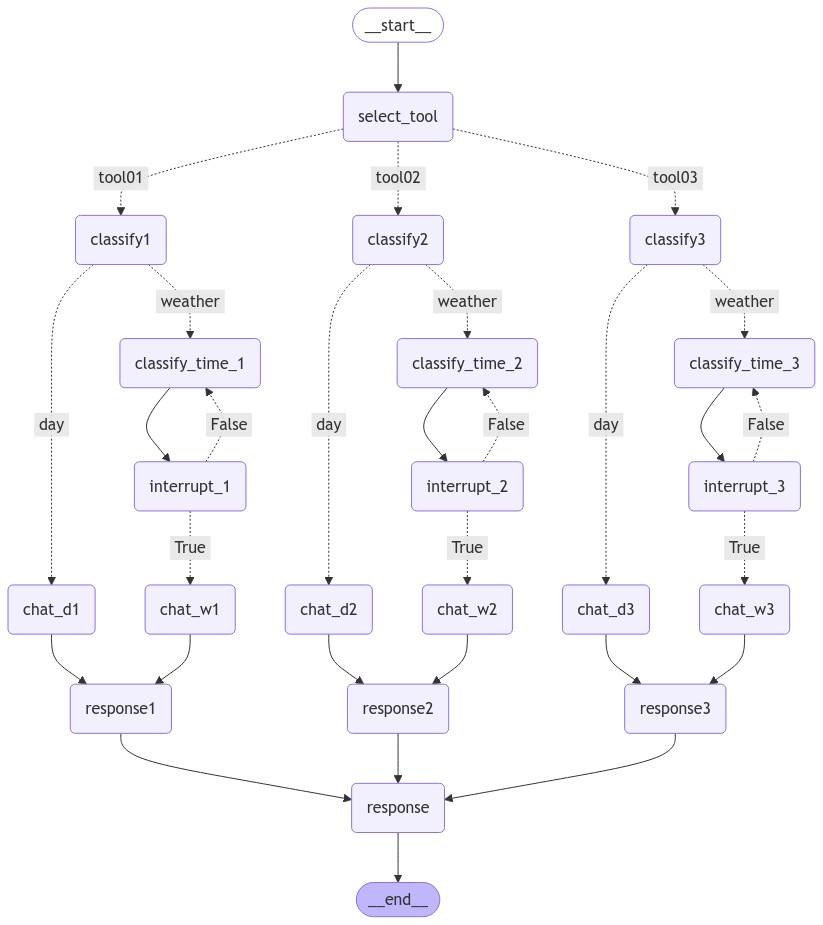

In [8]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:

def main():
    interrupt = False
    user_input = input("Your message: ")

    # インタラクションループ
    while user_input.lower() != "exit":
        event_list = []
        # 入力を State 構造に合わせる
        state = {
            "messages": [
                    ("system",""),

                    ("human", user_input),
            ]
        }
        thread_config = {"configurable": {"thread_id": "1"}}

        # 応答を取得して表示
        last_content = None

        for event in graph.stream(state, thread_config):
            #グラフ途中の中断を検出
            event_list.append(event)
            if "__interrupt__" in event:
                interrupt = True
                break
            # 最後の 'response' から 'messages' の content を取得
            if "response" in event and "messages" in event["response"]:
                messages = event["response"]["messages"]
                # AIMessage オブジェクトなら content 属性を取得
                if hasattr(messages, "content"):
                    last_content = messages.content

        # 最後のメッセージを表示
        if last_content:
            print("Assistant:", last_content)

        #中断した場合の処理を実装
        elif interrupt:
            interrupt = True
            for key in event_list[-2].keys():
                #中断した処理の直前のノードの名前によって処理を変える。（ただし、今回は一つだけ）
                if "classify_time" in key:
                    while interrupt:
                        #ユーザへの追加のメッセージを依頼する
                        user_input_add_times = input("天気を知りたい時間を入力してください（例：「午前中」「20時」など）: ")

                        add_state = {
                            "messages": [
                                    ("system",""),
                                    ("human", user_input),
                                    ("assistant", "天気を知りたい時間を入力してください（例：「午前中」「20時」など）: "),
                                    ("human", user_input_add_times),
                            ],
                            "advance_messages":user_input_add_times,
                        }

                        all_states = []
                        for state in graph.get_state_history(thread_config):
                            all_states.append(state)

                        to_replay = all_states[1]
                        branch_config = graph.update_state(config=to_replay.config, values=add_state)

                        for event in graph.stream(None, branch_config):
                            if "__interrupt__" in event:
                                interrupt = True
                                break
                            # 最後の 'response' から 'messages' の content を取得
                            if "response" in event and "messages" in event["response"]:
                                messages = event["response"]["messages"]
                                # AIMessage オブジェクトなら content 属性を取得
                                if hasattr(messages, "content"):
                                    last_content = messages.content

                        # 最後のメッセージを表示
                        if last_content:
                            print("Assistant:", last_content)
                            interrupt = False


        else:
            print("No content found.")

        #次のターンのメッセージ
        user_input = input("Your message: ")
    print("Goodbye!")

In [ ]:
main()